In [121]:
# @author: Vo Thien Hai Le (Seannie Le)

In [122]:
import pandas as pd
import numpy as np
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import holidays
import networkx as nx
from pandas.api.types import is_numeric_dtype, is_bool_dtype, is_object_dtype, is_categorical_dtype, CategoricalDtype
import shap # For SHAP values
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Dynamically handle small values that cause 'divide by zero' in matrix math
np.seterr(divide='ignore', invalid='ignore', over='ignore')

# --- Scikit-learn ---
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics.pairwise import rbf_kernel
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold # <-- For TUNING

# --- EconML for Causal ML ---
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter

from causallearn.utils.cit import fisherz
from causallearn.search.ConstraintBased.PC import pc 
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils

# --- DoWhy for Refutation ---
from dowhy import CausalModel
import dowhy.causal_refuters as dcr # <-- For ATE consistency check

import causalml
from causalml.inference.meta import BaseXRegressor # X-Learner implementation
from causalml.metrics import plot_gain, plot_qini

# --- Plotting Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (11, 6)
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "Times New Roman"
%matplotlib inline

## 1. Data Loading 

In [123]:
fpath = '../datasets/processed/final_df.csv'
df = pd.read_csv(fpath)
print(f"Successfully loaded processed data!")
if df.isnull().sum().sum() == 0:
    print("Data has no missing values.")

Successfully loaded processed data!
Data has no missing values.


In [124]:
df['distance_cat'] = pd.qcut(df['nsmiles'].dropna(), q=3, labels=['Short', 'Medium', 'Long'], duplicates='drop')

# Create categories, handle 0 carefully if fillna(0) was used
prem_nonzero = df.loc[df['origin_fare_premium'] != 0, 'origin_fare_premium']
df['premium_cat'] = pd.qcut(prem_nonzero.dropna(), q=3, labels=['Low Prem', 'Med Prem', 'High Prem'], duplicates='drop')

# Assign category for 0/NaN
df['premium_cat'] = df['premium_cat'].cat.add_categories(['Zero/NA']).fillna('Zero/NA') 

In [125]:
bool_cols = ['Q_2', 'Q_3', 'Q_4', 
             'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 
             'is_Q_with_Labor', 'is_Q_with_Christmas'] 
for col in bool_cols:
    if col in df.columns: df[col] = df[col].astype(float).astype(bool)
int_cols = ['passengers', 'Year', 'nsmiles', 'lg_carrier_is_lcc'] 
for col in int_cols:
    if col in df.columns: 
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
# df.info()

In [126]:
df['holiday_intensity'] = df[
    ['is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep',
     'is_Q_with_Labor', 'is_Q_with_Christmas']
].sum(axis=1)

In [127]:
# Add 'is_major_event' column based on Year and quarter
if 'quarter' not in df.columns and 'Q_2' in df.columns:
    print("Reconstructing 'quarter' column from dummies for event logic...")
    conditions = [
        df['Q_2'] == 1,
        df['Q_3'] == 1,
        df['Q_4'] == 1
    ]
    choices = [2, 3, 4]
    # If none are 1, it's Q1
    df['quarter'] = np.select(conditions, choices, default=1)
    
def check_major_events(row):
    year = row['Year']
    quarter = row['quarter']
    
    # 9/11 Attacks
    if year == 2001 and quarter in [3, 4]:
        return 1
    # COVID Pandemic
    if year == 2020 and quarter in [3, 4]:
        return 1
    if year == 2021 and quarter in [1]:
        return 1
    return 0

df['is_major_event'] = df.apply(check_major_events, axis=1)
print(df['is_major_event'].value_counts())
    

Reconstructing 'quarter' column from dummies for event logic...
is_major_event
0    110030
1      5002
Name: count, dtype: int64


## 2. Define Causal Analysis Variables

In [128]:
OUTCOME_CAUSAL = 'passengers'
TREATMENT_CAUSAL = 'fare'
print(f"Outcome (Y): {OUTCOME_CAUSAL}")
print(f"Treatment (T): {TREATMENT_CAUSAL}")

Outcome (Y): passengers
Treatment (T): fare


In [129]:
CONFOUNDERS_CAUSAL = [
    'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 
    'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax',
    'Year', 'lg_carrier_is_lcc', 'avg_fuel_price',
    'Q_2', 'Q_3', 'Q_4', 
    'holiday_intensity',
    'carrier_WN', 'carrier_DL', 'carrier_AA',
    'is_major_event'
]

In [130]:
# Features for Heterogeneity (X_het) - variables across which the treatment effect might vary
# Often a subset of W, or specific interaction candidates
FEATURES_HETEROGENEITY = [
    'nsmiles',                                    # effect might differ by distance
    'large_ms',                                   # effect might differ by market concentration
    'lg_carrier_is_lcc', 'origin_fare_premium',
    'distance_cat', 'premium_cat', 
    'Q_2', 'Q_3', 'Q_4',                          # temporal heterogeneity
    'carrier_WN', 'carrier_DL', 'carrier_AA',
    'avg_fuel_price', 
    'is_major_event',
    'holiday_intensity'
]
features_heterogeneity = [f for f in FEATURES_HETEROGENEITY if f in df.columns]
print(f"Features for Heterogeneity (X_het): {features_heterogeneity}")

Features for Heterogeneity (X_het): ['nsmiles', 'large_ms', 'lg_carrier_is_lcc', 'origin_fare_premium', 'distance_cat', 'premium_cat', 'Q_2', 'Q_3', 'Q_4', 'carrier_WN', 'carrier_DL', 'carrier_AA', 'avg_fuel_price', 'is_major_event', 'holiday_intensity']


In [131]:
numerical_features_to_scale = [
    'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium',
    'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year',
    'avg_fuel_price'
]
numerical_features_to_scale = [f for f in numerical_features_to_scale if f in df.columns]
print(f"Numerical features for scaling: {numerical_features_to_scale}")

Numerical features for scaling: ['nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', 'avg_fuel_price']


In [ ]:
label_map = {
    'Year': 'Year',
    'quarter': 'Quarter',
    'citymarketid_1': 'Origin ID',
    'citymarketid_2': 'Dest. ID',
    'city1': 'Origin City',
    'city2': 'Dest. City',
    'nsmiles': 'Distance (Miles)',
    'passengers': 'Passengers',
    'fare': 'Fare ($)',
    'carrier_lg': 'Lead Carrier',
    'large_ms': 'Share (Lead)',
    'fare_lg': 'Fare (Lead)',
    'carrier_low': 'Low Carrier',
    'lf_ms': 'Share (Low)',
    'fare_low': 'Fare (Low)',
    'origin_fare_premium': 'Origin Premium',
    'origin_perc_lcc_pax': 'LCC Share (Origin)',
    'dest_fare_premium': 'Destination Premium',      
    'dest_perc_lcc_pax': 'LCC Share (Dest)',      
    'route_id': 'Route ID',               
    'avg_fuel_price': 'Fuel Price',         
    'is_Q_with_NYD': 'Quarter with New Year’s Day',          
    'is_Q_with_Memorial': 'Quarter with Memorial Day',     
    'is_Q_with_Jul4_Indep': 'Quarter with Independence Day',   
    'is_Q_with_Labor': 'Quarter with Labor Day',              
    'is_Q_with_Christmas': 'Quarter with Christmas',     
    'period': 'Period',                 
    'lg_carrier_is_lcc': 'LCC Flag',
    'Q_2': 'Q2',
    'Q_3': 'Q3',
    'Q_4': 'Q4',
    'carrier_WN': 'Southwest',
    'carrier_DL': 'Delta',
    'carrier_AA': 'American',
    'num__nsmiles': 'Distance (Miles)',
    'num__large_ms': 'Share (Lead)',
    'num__origin_perc_lcc_pax': 'LCC Share (Origin)',
    'num__fare': 'Fare ($)',
    'num__origin_fare_premium': 'Origin Premium',
    'num__dest_fare_premium': 'Destination Premium',
    'num__lf_ms': 'Share (Low)',
    'num__Year': 'Year',
    'num__dest_perc_lcc_pax': 'LCC Share (Dest)',
    'num__fare_x_is_lcc': 'Fare x LCC',
    'num__log_fare': 'Logarithm of Fare',
    'remainder__is_Q_with_NYD': 'Quarter with New Year’s Day',
    'remainder__is_Q_with_Memorial': 'Quarter with Memorial Day',
    'remainder__Q_2': 'Q2',
    'remainder__is_Q_with_Thx': 'Quarter with Thanksgiving',
    'remainder__is_Q_with_Christmas': 'Quarter with Christmas',
    'remainder__is_Q_with_Jul4_Indep': 'Quarter with Independence Day',
    'remainder__is_Q_with_Labor': 'Quarter with Labor Day',
    'remainder__Q_3': 'Q3',
    'fare_x_is_lcc': 'Fare x LCC',
    'is_major_event': 'Major Shock',
    'holiday_intensity': 'Holiday Score',
    'log_fare': 'ln(Fare + 1)',
    'log_passengers': 'ln(Passengers + 1)',
    'distance_cat': 'Distance Categories', 
    'premium_cat': 'Premium Categories'
}

## 3. Create the ground truth

In [133]:
G = nx.DiGraph()

selected_features = [
    'fare',                 # Treatment (T)
    'passengers',           # Outcome (Y)
    'nsmiles',              # Confounder / Het. Feature (W/X)
    'large_ms',             # Confounder / Het. Feature (W/X)
    'Year',                 # Confounder (W - Time Trend)
    'lg_carrier_is_lcc',    # Confounder / Het. Feature (W/X)
    'origin_fare_premium',  # Confounder / Het. Feature (W/X)
    'holiday_intensity',    # Confounder(W - Summary of Holiday Effects)
    'avg_fuel_price', 
    'is_major_event'
]
# Add individual quarter controls for temporal shocks
selected_features.extend([q for q in ['Q_2', 'Q_3', 'Q_4',] if q in df.columns])
df_SF = df[selected_features]
display(df_SF)

,fare,passengers,nsmiles,large_ms,Year,lg_carrier_is_lcc,origin_fare_premium,holiday_intensity,avg_fuel_price,is_major_event,Q_2,Q_3,Q_4
0,159.59,16339,372,0.5209,2024,1,-0.00156,2,2.207,0,False,True,False
1,179.57,15842,1118,0.2565,2024,1,-0.10750,2,2.207,0,False,True,False
2,399.68,13767,2510,0.2642,2024,1,-0.00156,2,2.207,0,False,True,False
3,176.63,12511,989,0.4043,2024,1,0.03358,2,2.207,0,False,True,False
4,184.79,11466,773,0.4137,2024,0,-0.00315,2,2.207,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115027,138.88,111,550,0.2600,1996,0,-0.14690,1,0.562,0,False,False,False
115028,199.92,111,381,0.8400,1996,0,0.10675,1,0.562,0,False,False,False
115029,95.23,111,852,0.9300,1996,1,-0.48910,1,0.562,0,False,False,False
115030,164.99,110,1481,0.3000,1996,0,-0.16440,1,0.562,0,False,False,False


In [134]:
# Explicitly define confounders_causal used throughout the analysis
confounders_causal = [node for node in selected_features if node not in [TREATMENT_CAUSAL, OUTCOME_CAUSAL] and node in df.columns]
print(f"Confounders (W) for DML: {confounders_causal}")

Confounders (W) for DML: ['nsmiles', 'large_ms', 'Year', 'lg_carrier_is_lcc', 'origin_fare_premium', 'holiday_intensity', 'avg_fuel_price', 'is_major_event', 'Q_2', 'Q_3', 'Q_4']


In [135]:
causal_nodes = [node for node in selected_features if node in df.columns]
confounders = [node for node in causal_nodes if node not in ['fare', 'passengers']]
treatment_node = 'fare'
outcome_node = 'passengers'
G.add_nodes_from(causal_nodes)

In [136]:
edges = []
for w in confounders:
    edges.append((w, treatment_node)) # add edge W -> T
    edges.append((w, outcome_node))   # add edge W -> Y

# Add the main edge of interest from Treatment (T) to Outcome (Y)
edges.append((treatment_node, outcome_node)) # add T -> Y

G.add_edges_from(edges)

In [137]:
# Generate adjacency matrix
adj_matrix_GT = nx.adjacency_matrix(G, nodelist=causal_nodes).todense()
adj_df_GT = pd.DataFrame(adj_matrix_GT, columns=causal_nodes, index=causal_nodes)

# Print the adjacency matrix
print("Adjacency Matrix (Ground Truth):") 
print(adj_df_GT)

# Save the adjacency matrix as a .npy file
np.save('../outputs/ground_truth.npy', adj_df_GT.to_numpy())

Adjacency Matrix (Ground Truth):
                     fare  passengers  nsmiles  large_ms  Year  \
fare                    0           1        0         0     0   
passengers              0           0        0         0     0   
nsmiles                 1           1        0         0     0   
large_ms                1           1        0         0     0   
Year                    1           1        0         0     0   
lg_carrier_is_lcc       1           1        0         0     0   
origin_fare_premium     1           1        0         0     0   
holiday_intensity       1           1        0         0     0   
avg_fuel_price          1           1        0         0     0   
is_major_event          1           1        0         0     0   
Q_2                     1           1        0         0     0   
Q_3                     1           1        0         0     0   
Q_4                     1           1        0         0     0   

                     lg_carrier_is_lcc  or

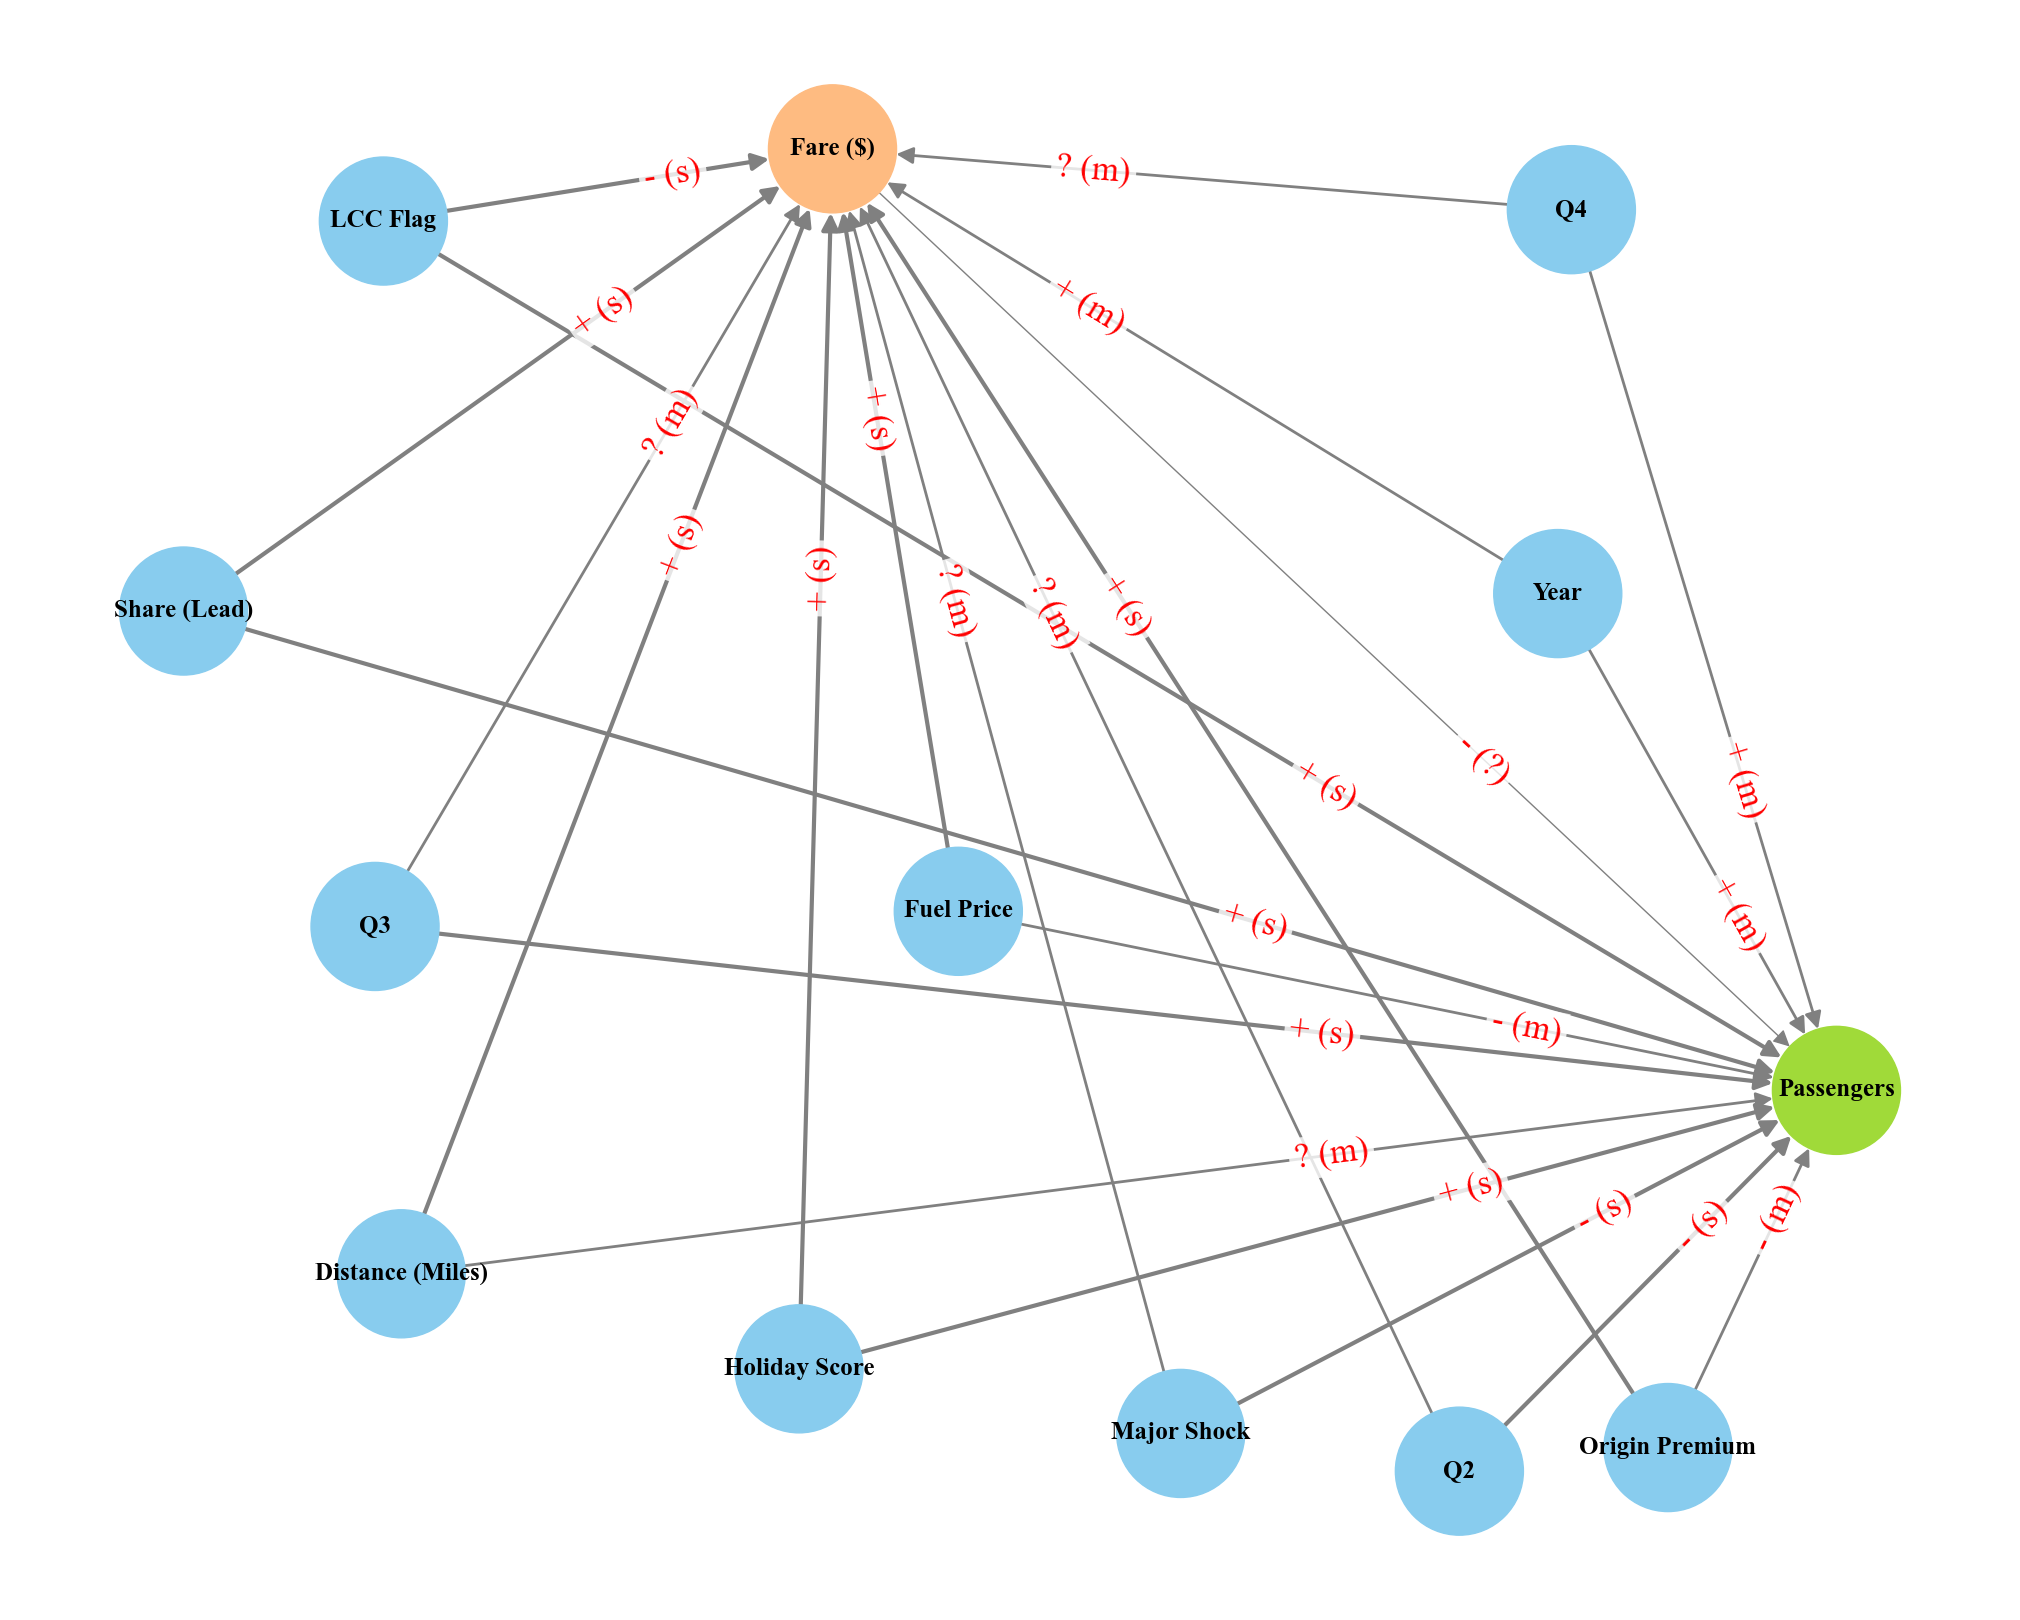

In [138]:
# Use existing label_map to create a label mapping for the nodes
node_label_map = {node: label_map.get(node, node) for node in G.nodes()}

# Plot the causal graph
plt.figure(figsize=(20, 16), facecolor='none', edgecolor='none')
pos = nx.spring_layout(G, seed=42, k=1.2)


# Move Major Shock slightly down and to the right
if 'is_major_event' in pos:
    pos['is_major_event'][0] += 0.10  # shift X right
    pos['is_major_event'][1] -= 0.20  # shift Y down
    
# Move Fuel Price slightly down 
if 'avg_fuel_price' in pos:
    pos['avg_fuel_price'][0] += 0.10  # shift X right
    pos['avg_fuel_price'][1] -= 0.30  # shift Y down
    
if 'origin_fare_premium' in pos:
    pos['origin_fare_premium'][0] -= 0.20  # shift X left
    pos['origin_fare_premium'][1] -= 0.20  # shift Y down

if 'Q_4' in pos:
    pos['Q_4'][0] += 0.40  # shift X right
    pos['Q_4'][1] += 0.20  # shift Y down

outcome_color = sns.color_palette("viridis")[5] 
treatment_color = sns.color_palette("magma")[5] 

node_colors = []
for node in G.nodes():
    if node == treatment_node:
        node_colors.append(treatment_color)
    elif node == outcome_node:
        node_colors.append(outcome_color)
    else:
        node_colors.append('#88CCEE')

# Add edge labels
edge_labels = {
    ('nsmiles', treatment_node): '+ (s)', # long distance -> higher fare
    ('large_ms', treatment_node): '+ (s)', # large market share -> higher fare (brand loyalty, pricing power)
    ('Year', treatment_node): '+ (m)', # year trend -> higher fare (inflation, fuel costs)
    ('lg_carrier_is_lcc', treatment_node): '- (s)', # low-cost carrier -> lower fare
    ('origin_fare_premium', treatment_node): '+ (s)', # high-cost airports -> higher fare
    ('holiday_intensity', treatment_node): '+ (s)', # holiday season -> higher fare
    ('avg_fuel_price', treatment_node): '+ (s)', # higher fuel prices -> higher fare
    ('is_major_event', treatment_node): '? (m)', # shock might raise or lower fares
    ('Q_2', treatment_node): '? (m)', 
    ('Q_3', treatment_node): '? (m)', 
    ('Q_4', treatment_node): '? (m)',
    
    ('nsmiles', outcome_node): '? (m)', # long distance ? passenger demand
    ('large_ms', outcome_node): '+ (s)', # large market share -> higher demand
    ('Year', outcome_node): '+ (m)', # long-term trend shows moderate growth in demand
    ('lg_carrier_is_lcc', outcome_node): '+ (s)',
    ('origin_fare_premium', outcome_node): '- (m)',
    ('holiday_intensity', outcome_node): '+ (s)', # holiday season -> higher fare
    ('avg_fuel_price', outcome_node): '- (m)', # higher fuel prices -> higher fare -> lower demand (cost sensitivity)
    ('is_major_event', outcome_node): '- (s)', # shock definitely lowers demand
    ('Q_2', outcome_node): '- (s)', # Q2 -> Lower Demand (e.g., COVID shock)
    ('Q_3', outcome_node): '+ (s)', # Q3 -> Higher Demand (e.g., Summer)
    ('Q_4', outcome_node): '+ (m)', # Q4 -> Higher Demand (e.g., Holidays)
    
    
    (treatment_node, outcome_node): '- (?)'
}

edge_weights = []
for u, v in G.edges():
    label = edge_labels.get((u, v), '')
    if '(s)' in label:
        edge_weights.append(3.0)
    elif '(m)' in label:
        edge_weights.append(2.0)
    else:
        edge_weights.append(1.0)

nx.draw(G, pos, 
        with_labels=False, # set false to use custom labels
        node_size=8500,
        node_color=node_colors, 
        arrows=True, 
        arrowsize=25,
        edge_color='gray', 
        width=edge_weights)

nx.draw_networkx_labels(G, pos, 
                        labels=node_label_map, 
                        font_size=18,
                        font_color='black', 
                        font_weight='bold'
                        )

nx.draw_networkx_edge_labels(G, pos, 
                             edge_labels=edge_labels, 
                             font_color='red', 
                             font_size=25, 
                             label_pos=0.65, 
                             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.savefig('../outputs/R_causal_ground_truth.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [139]:
df_GT = np.load('../outputs/ground_truth.npy')
print(df_GT)
print(type(df_GT))
print(df_GT.shape)
print(df_GT.dtype)

[[0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0]]
<class 'numpy.ndarray'>
(13, 13)
int64


## 4. Causal ML for Price Impact Estimation (Explanation)

**Goal**: Estimate the causal effect of 'fare' (T) on 'passengers' (Y), Controlling for confounders 'W'.

### 4.1. Prepare Data for Causal Model

In [140]:
Y = df[OUTCOME_CAUSAL].astype(float)
T = df[TREATMENT_CAUSAL].astype(float)
W = df[confounders_causal].copy() # confounders
X_het = df[features_heterogeneity].copy() # features for heterogeneity

In [141]:
X_het_cat_cols = [col for col in X_het.columns if is_object_dtype(X_het[col]) or is_categorical_dtype(X_het[col])]
if X_het_cat_cols:
    # One-Hot Encoding
    X_het = pd.get_dummies(X_het, columns=X_het_cat_cols, drop_first=True, dtype=int)
    print("X_het dtypes after encoding:")
    X_het.info(verbose=False)
else:
    print("\nNo string-based categorical features found in X_het to encode.")
    

X_het dtypes after encoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Columns: 18 entries, nsmiles to premium_cat_Zero/NA
dtypes: Int64(2), bool(3), float64(3), int64(10)
memory usage: 13.7 MB


In [142]:
fuel_price_col = 'avg_fuel_price'
# Convert boolean dummies in W and X_het to int (0/1) for econml models
print("Converting boolean/Int64 columns in W and X_het for econml...")
for df_causal in [W, X_het]:
    for col in df_causal.columns:
    # Convert potential boolean columns to int
        if is_bool_dtype(df_causal[col]):
            df_causal[col] = df_causal[col].astype(int)
        elif pd.api.types.is_integer_dtype(df_causal[col]):
            df_causal[col] = df_causal[col].astype(float)
        elif col == fuel_price_col and fuel_price_col in df_causal.columns:
            # Ensure fuel price is float
            df_causal[col] = df_causal[col].astype(float) 

Converting boolean/Int64 columns in W and X_het for econml...


In [143]:
print("\n Dtypes for W after conversion:")
W.info(verbose=False)
print("\n Dtypes for X_het after conversion:")
X_het.info(verbose=False)


 Dtypes for W after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Columns: 11 entries, nsmiles to Q_4
dtypes: float64(8), int64(3)
memory usage: 9.7 MB

 Dtypes for X_het after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Columns: 18 entries, nsmiles to premium_cat_Zero/NA
dtypes: float64(15), int64(3)
memory usage: 15.8 MB


### 4.2. Preprocessing (Scaling Confounders and Heterogeneity Features)

In [144]:
# Identify numeric columns within W and X_het that need scaling
num_W_to_scale = [col for col in W.columns if col in numerical_features_to_scale]
num_Xhet_to_scale = [col for col in X_het.columns if col in numerical_features_to_scale]

In [145]:
# Scaler for W
scaler_W = StandardScaler()
W[num_W_to_scale] = scaler_W.fit_transform(W[num_W_to_scale])
print(f"Scaled numerical confounders (W): {num_W_to_scale}")

Scaled numerical confounders (W): ['nsmiles', 'large_ms', 'Year', 'origin_fare_premium', 'avg_fuel_price']


In [146]:
# Scaler for X_het
scaler_Xhet = StandardScaler()
X_het[num_Xhet_to_scale] = scaler_Xhet.fit_transform(X_het[num_Xhet_to_scale])
print(f"Scaled numerical heterogeneity features (X_het): {num_Xhet_to_scale}")


Scaled numerical heterogeneity features (X_het): ['nsmiles', 'large_ms', 'origin_fare_premium', 'avg_fuel_price']


In [147]:
# Convert to numpy arrays for econml fit method
Y_np = Y.values.ravel()
T_np = T.values.ravel()
W_np = W.values; X_het_np = X_het.values

### 4.3. Estimate Average Treatment Effect (ATE) using LinearDML (Nuisance Tuning)

In [148]:
print("\n--- Tuning Nuisance Estimators (Gradient Boosting) ---")
# Define the base model for nuisance estimation (Gradient Boosting Regressor)
base_estimator = GradientBoostingRegressor(random_state=42)
# Define a minimal hyperparameter grid for demonstration/speed 
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05]
}


--- Tuning Nuisance Estimators (Gradient Boosting) ---


In [149]:
# 1. Tune model_y (E[Y|W])
gscv_y = GridSearchCV(
    estimator=base_estimator,
    param_grid=param_grid,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=0
)
gscv_y.fit(W_np, Y_np)
best_params_y = gscv_y.best_params_
model_y_tuned = GradientBoostingRegressor(random_state=42, **best_params_y)
print(f"Best parameters for model_y (E[Y|W]): {best_params_y}")

Best parameters for model_y (E[Y|W]): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [150]:
# 2. Tune model_t (E[T|W])
gscv_t = GridSearchCV(
    estimator=base_estimator,
    param_grid=param_grid,
    cv=KFold(n_splits=3, shuffle=True, random_state=123),
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=0
)
gscv_t.fit(W_np, T_np)
best_params_t = gscv_t.best_params_
model_t_tuned = GradientBoostingRegressor(random_state=123, **best_params_t)
print(f"Best parameters for model_t (E[T|W]): {best_params_t}")

Best parameters for model_t (E[T|W]): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [151]:
# Initialize LinearDML estimator
dml_estimator = LinearDML(model_y=model_y_tuned, model_t=model_t_tuned, discrete_treatment=False, cv=5, random_state=42)

In [152]:
print(f"\nFitting LinearDML model (Y:{Y_np.shape}, T:{T_np.shape}, W:{W_np.shape}) with TUNED nuisance estimators...")
# W contains confounders; X is None because LinearDML effect is constant by default
dml_estimator.fit(Y_np, T_np, X=None, W=W_np, inference='auto')


Fitting LinearDML model (Y:(115032,), T:(115032,), W:(115032, 11)) with TUNED nuisance estimators...


In [153]:
# Get the ATE summary
print("\nLinearDML ATE Summary (Tuned):")
ate_summary = dml_estimator.summary(alpha=0.05) # 95% confidence interval (CI)
print(ate_summary)

ate_inference_results = dml_estimator.effect_inference()

ate_point_estimate_val = ate_inference_results.point_estimate
ate_stderr_val = ate_inference_results.stderr
ate_pvalue_val = ate_inference_results.pvalue()

ate_point_estimate = ate_point_estimate_val.item() 
ate_stderr = ate_stderr_val.item() 
ate_pvalue = ate_pvalue_val.item()

print(f"\nEstimated Average Treatment Effect (ATE) of Fare on Passengers: {ate_point_estimate:.3f}")
print(f"Standard Error: {ate_stderr:.3f}")
print(f"P-value: {ate_pvalue:.3f}")

print("\nInterpretation of ATE:")
print(f"On average, across all routes and time periods, a $1 increase in 'fare'")
print(f"is estimated to cause a change of approximately {ate_point_estimate:.1f} passengers per day,")
print(f"after controlling for the confounding effects of specified W variables.")

if ate_pvalue < 0.05: 
    print("This effect is statistically significant at the 5% level (rejection of null hypothesis of zero effect).")
else: 
    print("This effect is not statistically significant at the 5% level.")



LinearDML ATE Summary (Tuned):
Coefficient Results:  X is None, please call intercept_inference to learn the constant!
                        CATE Intercept Results                       
               point_estimate stderr  zstat  pvalue ci_lower ci_upper
---------------------------------------------------------------------
cate_intercept         -4.008  0.061 -65.879    0.0   -4.128   -3.889
---------------------------------------------------------------------

<sub>A linear parametric conditional average treatment effect (CATE) model was fitted:
$Y = \Theta(X)\cdot T + g(X, W) + \epsilon$
where for every outcome $i$ and treatment $j$ the CATE $\Theta_{ij}(X)$ has the form:
$\Theta_{ij}(X) = X' coef_{ij} + cate\_intercept_{ij}$
Coefficient Results table portrays the $coef_{ij}$ parameter vector for each outcome $i$ and treatment $j$. Intercept Results table portrays the $cate\_intercept_{ij}$ parameter.</sub>

Estimated Average Treatment Effect (ATE) of Fare on Passengers: -4.008


#### Leave-One-Out Robustness Check

In [154]:
major_confounders = ['large_ms', 'nsmiles', 'avg_fuel_price', 'origin_fare_premium', 'is_major_event']
loo_results = {}

print("\nRunning Leave-One-Out Analysis...")
for col in major_confounders:
    # Create a subset of confounders excluding 'col'
    reduced_W = [c for c in confounders_causal if c != col]
    W_loo = df[reduced_W].values
    
    # Fit model
    model_loo = LinearDML(model_y=model_y_tuned, model_t=model_t_tuned, discrete_treatment=False, cv=3)
    model_loo.fit(Y_np, T_np, W=W_loo)
    
    ate_loo = model_loo.effect_inference().point_estimate.item()
    pct_change = ((ate_loo - ate_point_estimate) / ate_point_estimate) * 100
    loo_results[col] = {"New ATE": ate_loo, "% Change": pct_change}

loo_df = pd.DataFrame(loo_results).T
print(loo_df)


Running Leave-One-Out Analysis...
                      New ATE   % Change
large_ms            -4.259595   6.268114
nsmiles             -3.768895  -5.973846
avg_fuel_price      -3.896003  -2.802760
origin_fare_premium -3.457958 -13.731088
is_major_event      -3.980672  -0.690446


### 4.4. Estimate Conditional Average Treatment Effects (CATE) using CausalForestDML

In [155]:
print("\n--- Estimating CATE using CausalForestDML ---")

# Initialize CausalForestDML estimator
cf_estimator = CausalForestDML(model_y=model_y_tuned, model_t=model_y_tuned,
                               discrete_treatment=False, n_estimators=200,
                               min_samples_leaf=20, max_depth=10,
                               cv=5, random_state=42, n_jobs=-1)


--- Estimating CATE using CausalForestDML ---


In [156]:
print(f"Fitting CausalForestDML model (Y:{Y_np.shape}, T:{T_np.shape}, W:{W_np.shape}, X:{X_het_np.shape})...")
# X=X_het_np tells the model to find heterogeneity based on these features
cf_estimator.fit(Y_np, T_np, X=X_het_np, W=W_np, inference='auto')

Fitting CausalForestDML model (Y:(115032,), T:(115032,), W:(115032, 11), X:(115032, 18))...


In [157]:
# Get CATE estimates for each observation
print("Calculating CATE estimates...")
cate_estimates = cf_estimator.effect(X_het_np)

# Add CATEs back to an unscaled dataframe for analysis
# Re-select original (unscaled) heterogeneity features
df_cate_analysis = df.loc[df_causal.index, features_heterogeneity].copy()
df_cate_analysis['CATE_fare_on_passengers'] = cate_estimates

Calculating CATE estimates...


In [158]:
print("\nCATE Estimation Summary:")
print(df_cate_analysis['CATE_fare_on_passengers'].describe())


CATE Estimation Summary:
count    115032.000000
mean         -4.572146
std           5.417431
min         -54.666315
25%          -7.070862
50%          -3.453394
75%          -1.431221
max          26.163812
Name: CATE_fare_on_passengers, dtype: float64


Plotting CATE distribution...


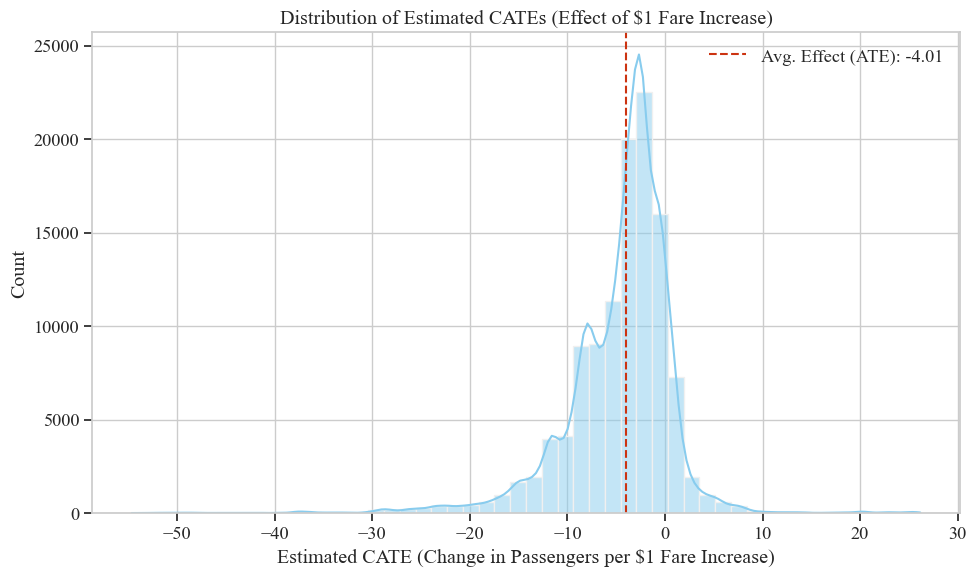

In [159]:
# Visualize CATE distribution
print("Plotting CATE distribution...")
plt.figure(figsize=(10, 6), facecolor='white')
sns.histplot(df_cate_analysis['CATE_fare_on_passengers'], kde=True, bins=50, color='#88CCEE')
plt.title('Distribution of Estimated CATEs (Effect of $1 Fare Increase)')
plt.xlabel('Estimated CATE (Change in Passengers per $1 Fare Increase)')
# Use ATE from LinearDML for comparison
plt.axvline(ate_point_estimate, color='#CC3311', linestyle='--', label=f'Avg. Effect (ATE): {ate_point_estimate:.2f}')
plt.legend(); 
plt.grid(True)
plt.tight_layout()
plt.savefig('../outputs/R_CML_dist_est_CATEs_CF.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

### 4.5. Interpret Heterogeneity

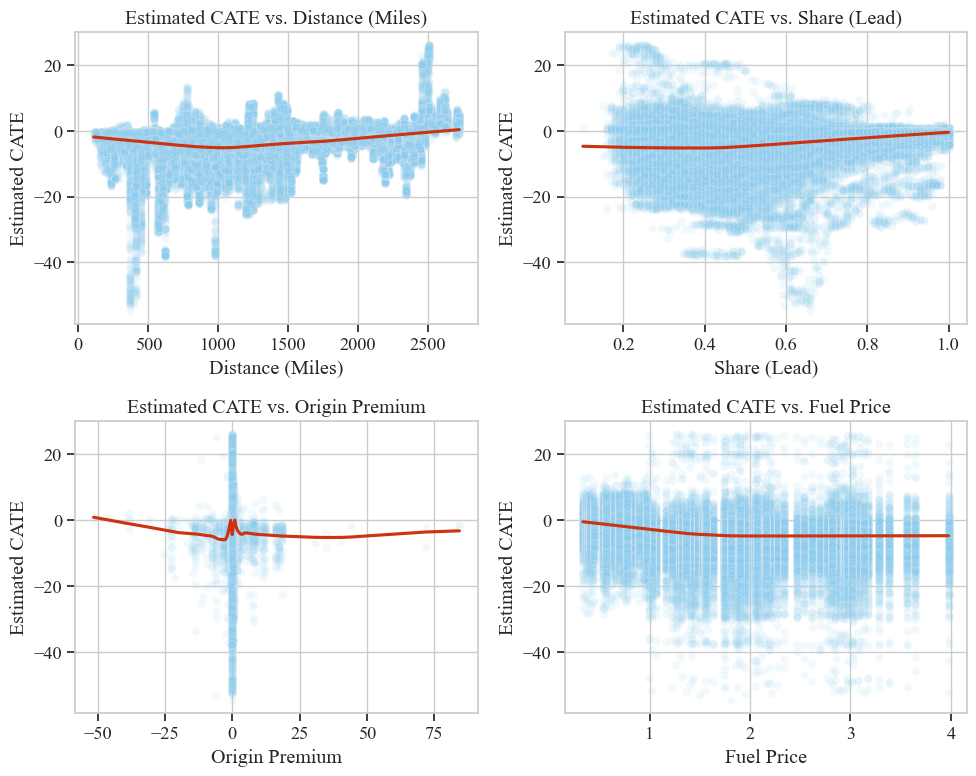

In [160]:
# Plot CATE against key continuous heterogeneity features (original scale)
cont_het_features = ['nsmiles', 'large_ms', 'origin_fare_premium', 'avg_fuel_price']
cont_het_features = [f for f in cont_het_features if f in df_cate_analysis.columns]
n_plots = len(cont_het_features)
max_cols = 2
ncols = min(n_plots, max_cols)
nrows = (n_plots + ncols - 1) // ncols
plt.figure(figsize=(ncols*5, nrows*4), facecolor='white')

for i, col in enumerate(cont_het_features):
    ax = plt.subplot(nrows, ncols, i + 1)
    
    sns.scatterplot(data=df_cate_analysis, x=col, y='CATE_fare_on_passengers', alpha=0.1, ax=ax, color='#88CCEE')
    
    # Add a trend line
    sns.regplot(data=df_cate_analysis, x=col, y='CATE_fare_on_passengers', scatter=False, lowess=True, line_kws={'color': '#CC3311'}, ax=ax)
    
    ax.set_title(f'Estimated CATE vs. {label_map.get(col)}')
    ax.set_xlabel(label_map.get(col))
    ax.set_ylabel('Estimated CATE')
    ax.grid(True)
    
plt.tight_layout()
plt.savefig('../outputs/R_CML_CATE_plots_num_vars.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

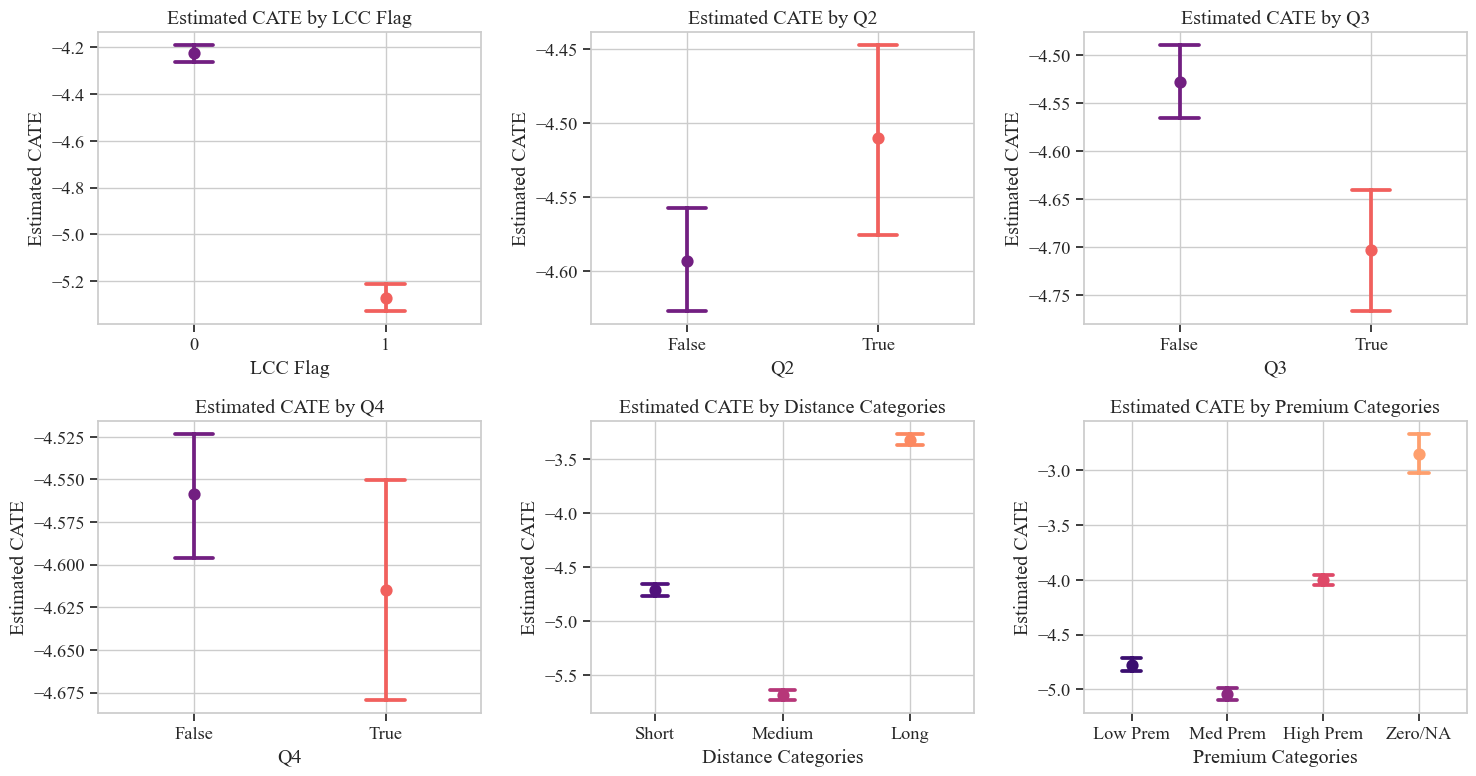

In [161]:
# Plot CATE against key categorical/binary heterogeneity features (original scale)
cat_het_features = ['lg_carrier_is_lcc', 'Q_2', 'Q_3', 'Q_4', 'distance_cat', 'premium_cat'] 
cat_het_features = [f for f in cat_het_features if f in df_cate_analysis.columns]

n_plots = len(cat_het_features)
max_cols = 3
ncols = min(n_plots, max_cols)
nrows = (n_plots + ncols - 1) // ncols
plt.figure(figsize=(ncols*5, nrows*4), facecolor='white')
for i, col in enumerate(cat_het_features):
    ax = plt.subplot(nrows, ncols, i + 1)
    
    sns.pointplot(data=df_cate_analysis, x=col, y='CATE_fare_on_passengers', 
                  hue=col, legend=False, errorbar=('ci', 95), capsize=.2,
                  linestyles='none', palette='magma', ax=ax)
    
    ax.set_title(f'Estimated CATE by {label_map.get(col)}')
    ax.set_xlabel(label_map.get(col))
    ax.set_ylabel('Estimated CATE')
    ax.grid(True)
    
plt.tight_layout()
plt.savefig('../outputs/R_CML_CATE_plots_categorical_vars.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()



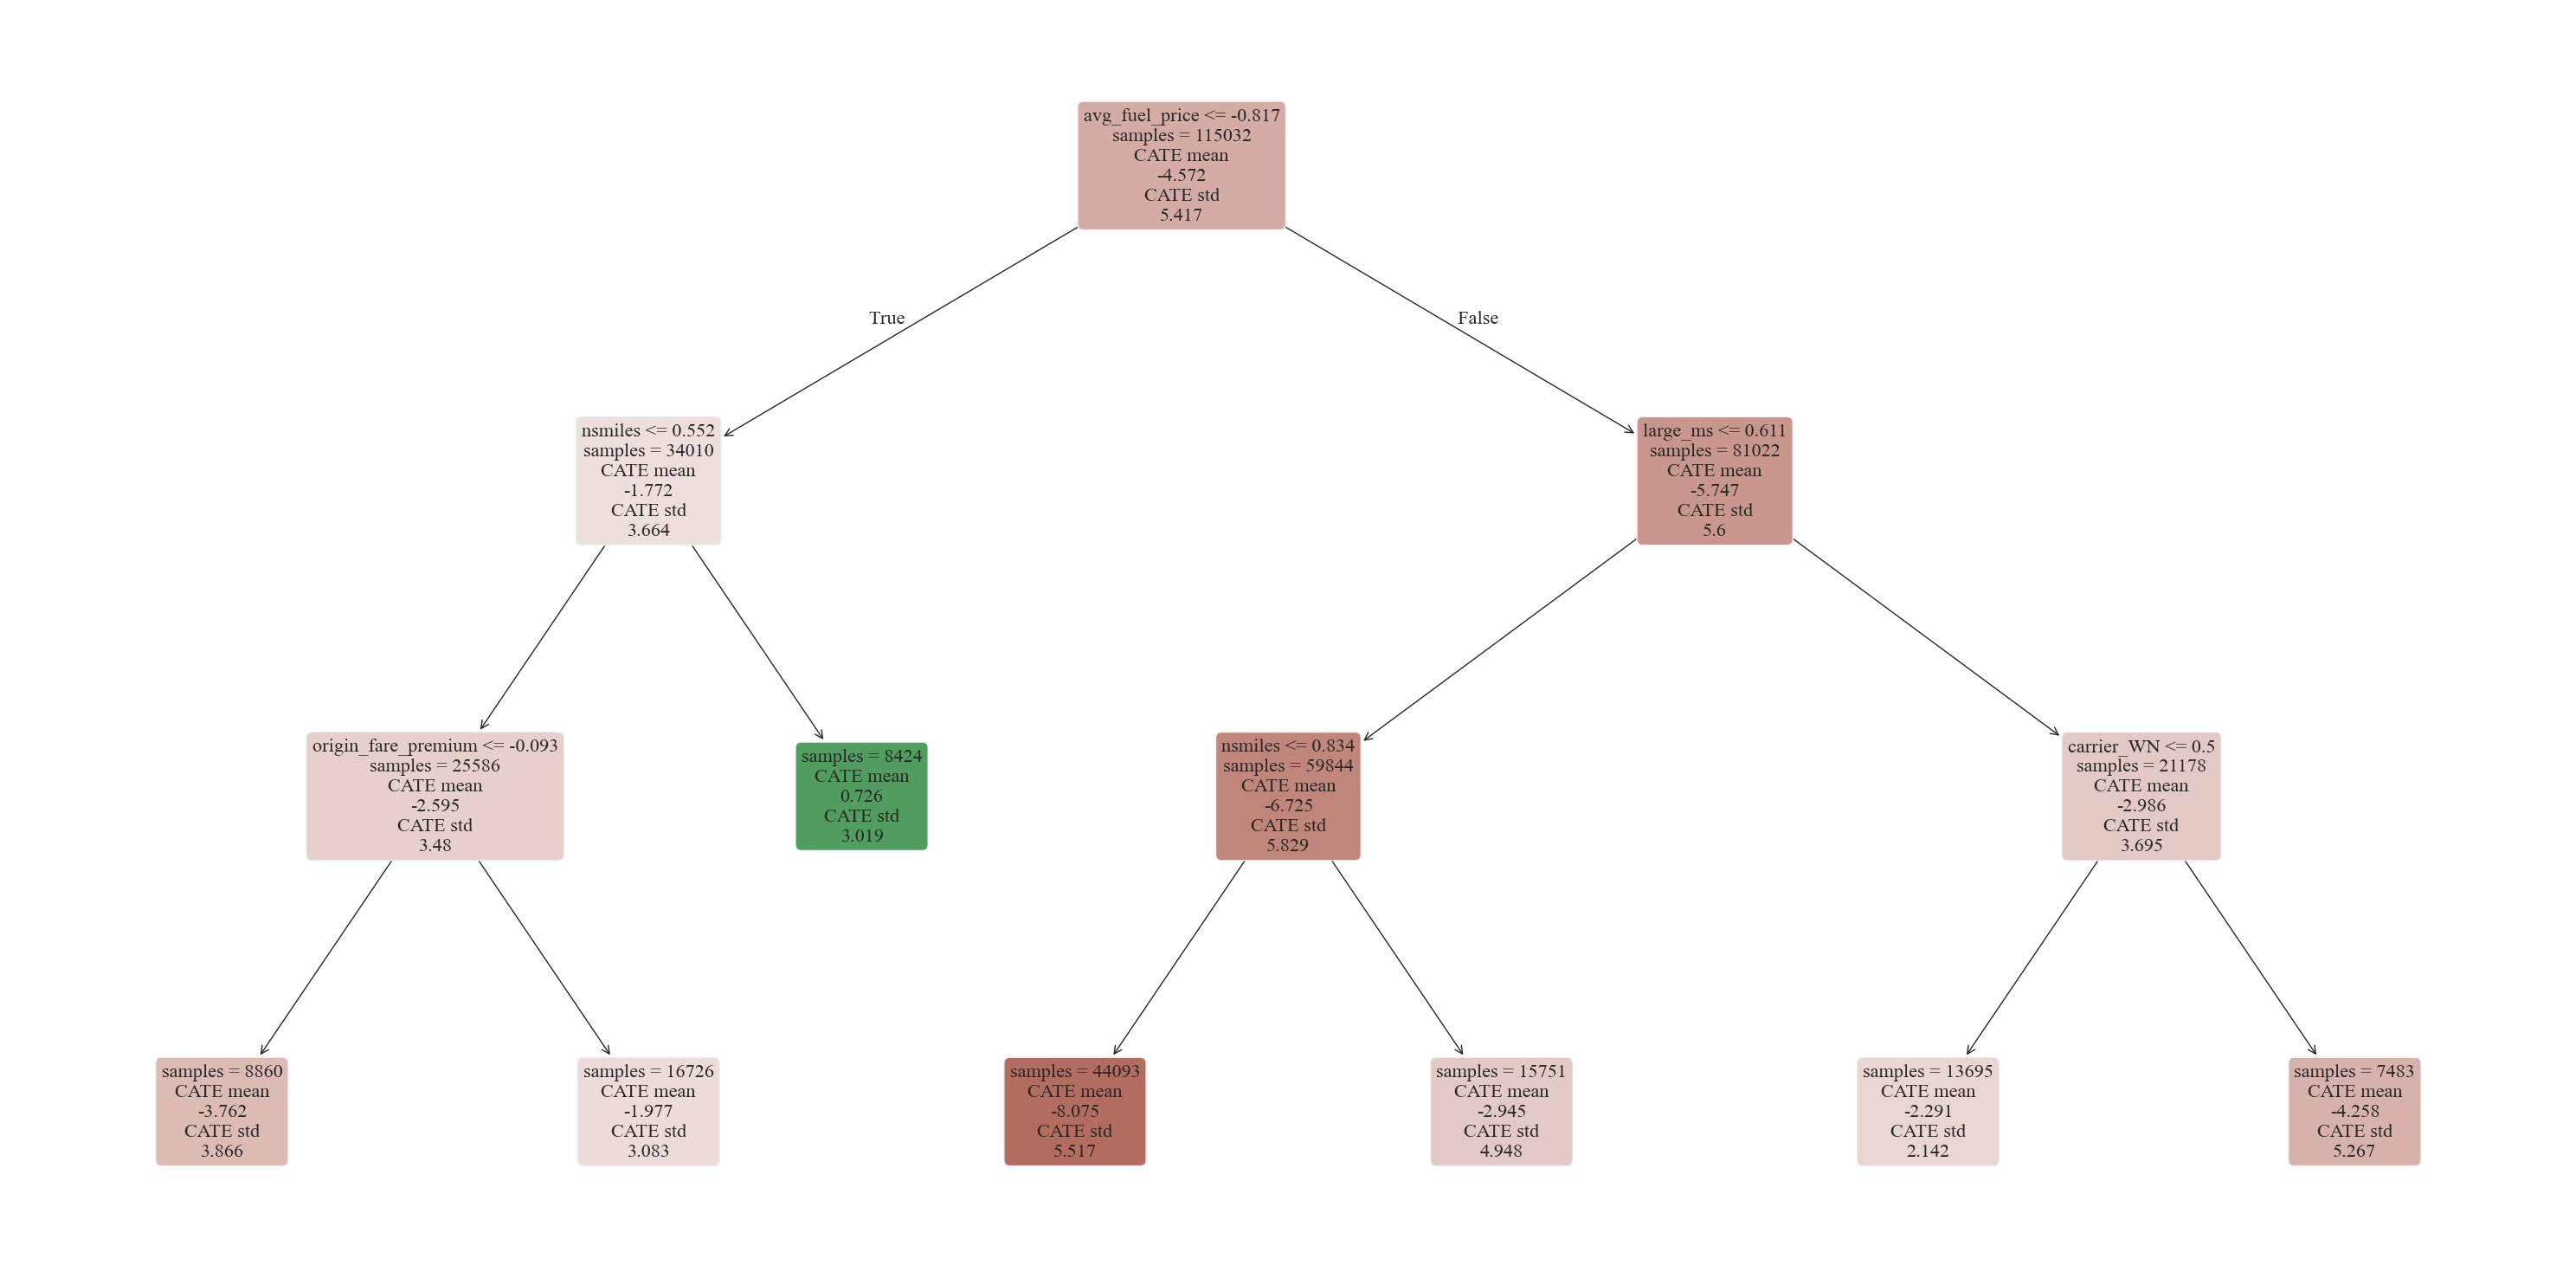

Interpretation: Tree shows features splitting data into segments with different CATEs.


In [162]:
# Interpret with SingleTreeCateInterpreter
# Use the SCALED X_het features (X_het_np) for fitting the tree
# Use original feature names from X_het for plotting labels
X_het_feature_names = X_het.columns.tolist()
tree_interpreter = SingleTreeCateInterpreter(include_model_uncertainty=False, max_depth=3, min_samples_leaf=int(len(df)*0.05))

tree_interpreter.interpret(cf_estimator, X_het_np) # fit interpreter on CATE model & SCALED features X

plt.figure(figsize=(30, 15))
tree_interpreter.plot(feature_names=X_het_feature_names, fontsize=16)
plt.tight_layout()
plt.savefig('../outputs/R_CML_CATE_tree_feature_splitting.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()
print("Interpretation: Tree shows features splitting data into segments with different CATEs.")

## 5. Subgroup ATE Analysis

In [163]:
# Estimate CausalForestDML CATE 
cate_estimates_cfdml = cf_estimator.effect(X_het_np)

In [164]:
# Use CATE estimates from CausalForestDML for subgroup averages
df_cate_analysis = df.copy() 
df_cate_analysis['CATE'] = cate_estimates_cfdml

### 5.1. LCC vs Non-LCC


Calculating ATE for LCC vs Non-LCC subgroups...
                       mean       std  count  ci_lower  ci_upper
lg_carrier_is_lcc                                               
0                 -4.225246  5.312680  76851 -4.262808 -4.187684
1                 -5.270388  5.557155  38181 -5.326131 -5.214646


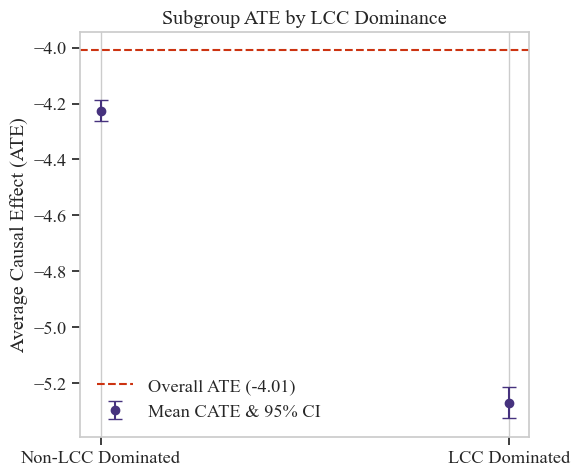

In [165]:
print("\nCalculating ATE for LCC vs Non-LCC subgroups...")
subgroup_ate_lcc = df_cate_analysis.groupby('lg_carrier_is_lcc')['CATE'].agg(['mean', 'std', 'count'])

# Approximate CI: mean +/- 1.96 * (std / sqrt(count))
subgroup_ate_lcc['ci_lower'] = subgroup_ate_lcc['mean'] - 1.96 * (subgroup_ate_lcc['std'] / np.sqrt(subgroup_ate_lcc['count']))
subgroup_ate_lcc['ci_upper'] = subgroup_ate_lcc['mean'] + 1.96 * (subgroup_ate_lcc['std'] / np.sqrt(subgroup_ate_lcc['count']))
print(subgroup_ate_lcc)

# Plot
plt.figure(figsize=(6, 5), facecolor='white')
plt.errorbar(x=subgroup_ate_lcc.index, y=subgroup_ate_lcc['mean'], 
             yerr=(subgroup_ate_lcc['mean'] - subgroup_ate_lcc['ci_lower'], subgroup_ate_lcc['ci_upper'] - subgroup_ate_lcc['mean']),
             fmt='o', capsize=5, label='Mean CATE & 95% CI')
plt.axhline(ate_point_estimate, color='#CC3311', linestyle='--', label=f'Overall ATE ({ate_point_estimate:.2f})')
plt.xticks(ticks=[0, 1], labels=['Non-LCC Dominated', 'LCC Dominated'])
plt.ylabel('Average Causal Effect (ATE)')
plt.title('Subgroup ATE by LCC Dominance')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../outputs/R_CML_subgroup_ATE_by_LCC.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

### 5.2. Distance Categories


Calculating ATE for Distance Categories...
                  mean       std  count  ci_lower  ci_upper
distance_cat                                               
Short        -4.710153  5.765408  38522 -4.767728 -4.652579
Medium       -5.678146  4.702510  38427 -5.725164 -5.631128
Long         -3.316557  5.466631  38083 -3.371461 -3.261652


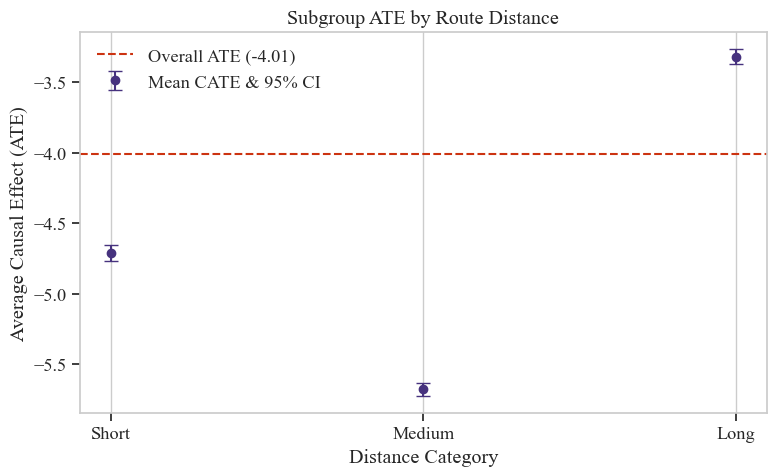

In [166]:
print("\nCalculating ATE for Distance Categories...")

# Use original nsmiles for categorization
df_cate_analysis['distance_cat'] = pd.qcut(df['nsmiles'].astype(float), q=3, labels=['Short', 'Medium', 'Long'], duplicates='drop')
subgroup_ate_dist = df_cate_analysis.groupby('distance_cat', observed=False)['CATE'].agg(['mean', 'std', 'count'])
subgroup_ate_dist['ci_lower'] = subgroup_ate_dist['mean'] - 1.96 * (subgroup_ate_dist['std'] / np.sqrt(subgroup_ate_dist['count']))
subgroup_ate_dist['ci_upper'] = subgroup_ate_dist['mean'] + 1.96 * (subgroup_ate_dist['std'] / np.sqrt(subgroup_ate_dist['count']))
print(subgroup_ate_dist)

plt.figure(figsize=(8, 5), facecolor='white')
plt.errorbar(x=subgroup_ate_dist.index, y=subgroup_ate_dist['mean'],
             yerr=(subgroup_ate_dist['mean'] - subgroup_ate_dist['ci_lower'], subgroup_ate_dist['ci_upper'] - subgroup_ate_dist['mean']),
             fmt='o', capsize=5, label='Mean CATE & 95% CI')
plt.axhline(ate_point_estimate, color='#CC3311', linestyle='--', label=f'Overall ATE ({ate_point_estimate:.2f})')
plt.ylabel('Average Causal Effect (ATE)')
plt.xlabel('Distance Category')
plt.title('Subgroup ATE by Route Distance')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('../outputs/R_CML_subgroup_ATE_by_distance.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()


### 5.3. CATE Decile Plot

Creating CATE Decile Plot...


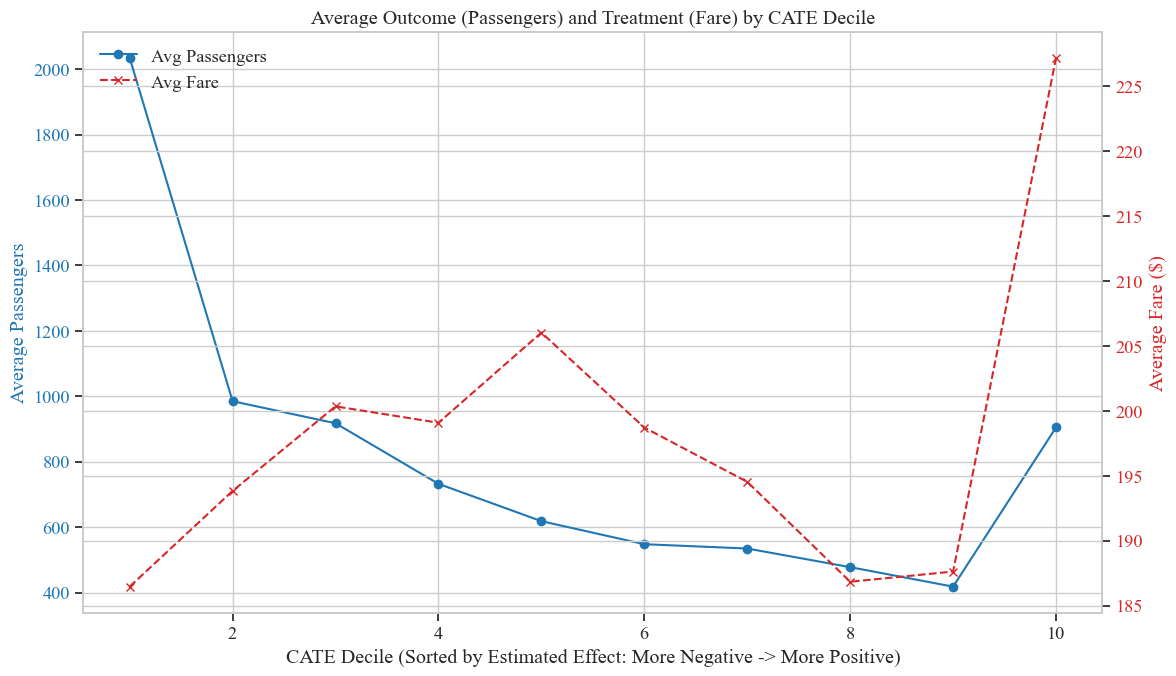


Interpretation:
Check trends across deciles, e.g., do deciles with more negative CATEs (higher price sensitivity) show lower average passengers?


In [167]:
print("Creating CATE Decile Plot...")
# plt.style.use('seaborn-v0_8-whitegrid')

# Use df_cate_analysis which has unscaled features and CATEs
df_decile = df.copy() 
df_decile['CATE'] = cate_estimates_cfdml 

# Sort by CATE and create deciles
df_decile = df_decile.sort_values('CATE')
df_decile['CATE_decile'] = pd.qcut(df_decile['CATE'], q=10, labels=False, duplicates='drop') + 1 # labels 1-10

# Calculate average outcome and treatment per decile
decile_agg = df_decile.groupby('CATE_decile')[['passengers', 'fare', 'CATE']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(12, 7))
# fig.set_facecolor('white')
# ax1.set_facecolor('white')

color1 = 'tab:blue'
ax1.set_xlabel('CATE Decile (Sorted by Estimated Effect: More Negative -> More Positive)')
ax1.set_ylabel('Average Passengers', color=color1)
ax1.plot(decile_agg['CATE_decile'], decile_agg['passengers'], color=color1, marker='o', label='Avg Passengers')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

ax2 = ax1.twinx()
# ax2.set_facecolor('white')
color2 = 'tab:red'
ax2.set_ylabel('Average Fare ($)', color=color2)
ax2.plot(decile_agg['CATE_decile'], decile_agg['fare'], color=color2, marker='x', linestyle='--', label='Avg Fare')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Average Outcome (Passengers) and Treatment (Fare) by CATE Decile')
lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')
fig.tight_layout()
plt.savefig('../outputs/R_CML_CATE_decile_plot.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

print("\nInterpretation:\nCheck trends across deciles, e.g., do deciles with more negative CATEs (higher price sensitivity) show lower average passengers?")

## 6. Sensitivity Analysis (dowhy)

Test robustness to unobserved confounders

### 6.1. Create DoWhy Causal Model

In [168]:
dowhy_cols = [OUTCOME_CAUSAL, TREATMENT_CAUSAL] + confounders_causal
df_dowhy = df[dowhy_cols].copy()

# Convert boolean/Int64 columns to int/float for dowhy compatibility
for col in df_dowhy.columns:
    if is_bool_dtype(df_dowhy[col]):
        df_dowhy[col] = df_dowhy[col].astype(int)
    elif pd.api.types.is_integer_dtype(df_dowhy[col]):
        df_dowhy[col] = df_dowhy[col].astype(float)
    elif col == fuel_price_col and fuel_price_col in df_dowhy.columns:
        df_dowhy[col] = df_dowhy[col].astype(float)

# Define graph structure: W -> T, W -> Y (Updated with full W list)
confounder_names_dowhy = W.columns.tolist() # get final confounder names

graph_str_minimal = f"digraph {{ {TREATMENT_CAUSAL} -> {OUTCOME_CAUSAL} }}"

In [169]:
print("\nInitializing DoWhy CausalModel using 'common_causes' list...")

# Initialize CausalModel
model_dowhy = CausalModel(
    data=df_dowhy,
    treatment=TREATMENT_CAUSAL,
    outcome=OUTCOME_CAUSAL,
    graph=None,
    common_causes=confounder_names_dowhy
)
print("DoWhy CausalModel initialized.")


Initializing DoWhy CausalModel using 'common_causes' list...
DoWhy CausalModel initialized.


### 6.2. Identify Estimand

In [170]:
identified_estimand = model_dowhy.identify_effect(proceed_when_unidentifiable=True)
print("\nIdentified Estimand:")
print(identified_estimand)


Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                           ↪
───────(E[passengers|is_major_⟨event,⟩_fuel_price,Q_4,large_ms,Year,Q_2,nsmile ↪
d[fare]                                                                        ↪

↪                                                                
↪ s,origin_fare_premium,lg_carrier_is_lcc,holiday_intensity,Q_3])
↪                                                                
Estimand assumption 1, Unconfoundedness: If U→{fare} and U→passengers then P(passengers|fare,is_major_event,avg_fuel_price,Q_4,large_ms,Year,Q_2,nsmiles,origin_fare_premium,lg_carrier_is_lcc,holiday_intensity,Q_3,U) = P(passengers|fare,is_major_event,avg_fuel_price,Q_4,large_ms,Year,Q_2,nsmiles,origin_fare_premium,lg_carrier_is_lcc,holiday_intensity,Q_3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Es

The primary identification strategy (controlling for the observed confounders W using the backdoor criterion, which is what DML does) is valid according to the causal graph you assumed. 

=> Proceed with the estimation and refutation steps based on this identification result.

### 6.3. Sensitivity Analysis (AddUnobservedCommonCause)


Estimating DML Effect natively through DoWhy...


/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was p

DoWhy Native DML ATE Estimate: -4.008

--- Running DML-Based Sensitivity Analysis ---


/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was p

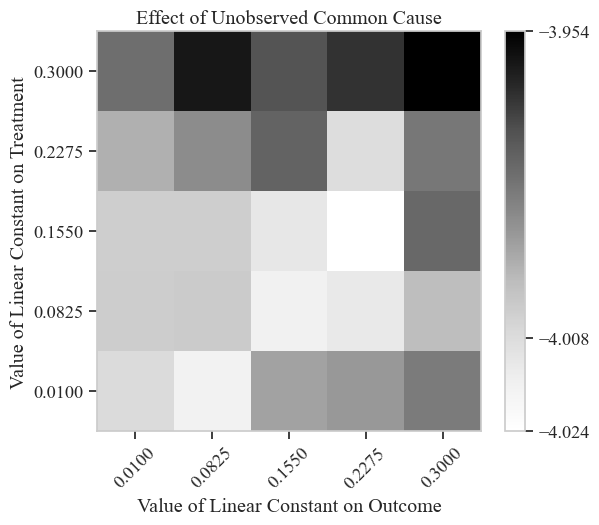


Refuter Baseline (Zero Confounding): -4.024

Sensitivity Analysis Results:
Refute: Add an Unobserved Common Cause
Estimated effect:-4.007849806965496
New effect:(np.float64(-4.024163122006207), np.float64(-3.9544989077027224))



In [171]:
print("\nEstimating DML Effect natively through DoWhy...")

# Pass tuned parameters directly into DoWhy's EconML integration
dml_estimate_dowhy = model_dowhy.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDML", # NATIVE DML CALL
    target_units="ate",
    method_params={
        "init_params": {
            'model_y': GradientBoostingRegressor(random_state=42, **best_params_y),
            'model_t': GradientBoostingRegressor(random_state=123, **best_params_t),
            'discrete_treatment': False,
            'cv': 5,
            'random_state': 42
        },
        "fit_params": {}
    }
)

print(f"DoWhy Native DML ATE Estimate: {dml_estimate_dowhy.value:.3f}") 


print("\n--- Running DML-Based Sensitivity Analysis ---")
sensitivity_results = model_dowhy.refute_estimate(
    identified_estimand,
    dml_estimate_dowhy, # Pass the REAL DML estimate, NOT the dummy
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=np.linspace(0.01, 0.3, 5),
    effect_strength_on_outcome=np.linspace(0.01, 0.3, 5)
)

# Explicitly check refuter baseline
print(f"\nRefuter Baseline (Zero Confounding): {sensitivity_results.new_effect[0]:.3f}")
print("\nSensitivity Analysis Results:")
print(sensitivity_results)

The consistency of the 'New Effect' values, despite the varying effect_strength on T and Y, demonstrates the robustness of the ATE estimate.

**Purpose**

This test checks how robust your estimated ATE (~ -4.008) is to a potential unobserved confounder that might affect both fare (treatment) and passengers (outcome). It simulates such a confounder with varying strengths (affecting treatment and outcome with correlations from 0.01 up to 0.3, based on the linspace settings).

**Result**

The New effect: (-4.013..., -3.944 ...) shows the range of ATE estimates produced under these different simulated confounding scenarios.

=> Even when assuming an unobserved confounder with a reasonably strong linear effect (up to 0.3 correlation with both treatment and outcome), the estimated treatment effect remains consistently negative and does not cross zero. While the magnitude slightly changes (from -4.008 down to around -4.013), the core conclusion of a negative effect holds. 

=> This suggests the finding is relatively robust to unobserved confounding of this magnitude. The heatmap visually confirms that the estimated effect stays negative across the tested range of confounder strengths.

In [173]:
# --- 2.5: Perform Placebo Treatment Refutation ---
print("\nPerforming Placebo Treatment Refutation...")
placebo_results = model_dowhy.refute_estimate(
    identified_estimand,
    dml_estimate_dowhy, # pass the estimate object
    method_name="placebo_treatment_refuter",
    placebo_type="permute", 
    num_simulations=20
)
print("\nPlacebo Treatment Refutation Results:")
print(placebo_results)


Performing Placebo Treatment Refutation...


/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was p


Placebo Treatment Refutation Results:
Refute: Use a Placebo Treatment
Estimated effect:-4.007849806965496
New effect:0.0025053252826203096
p value:0.4720116733057126



#### Placebo Treatment Refutation (placebo_treatment_refuter)

This test replaces the actual treatment (fare) with random noise (a placebo that should have no real effect) and re-estimates the effect. 
A good causal model should find an effect close to zero for the placebo.

**Result**

The output shows New effect: 0.0025... (very close to zero) and P-value: 0.472 > 0.05....

A high p-value means we cannot reject the null hypothesis that the effect of the placebo treatment is zero. In other words, the model correctly found no statistically significant effect when the real treatment was replaced by random noise.

The significant negative effect for the actual fare treatment (ATE ≈ -4.008) is likely a genuine causal finding related to fare itself, rather than just an artifact of the model finding patterns in noise.

Both refutation tests provide positive support for the estimated ATE. 

## 7. SHAP Values For Nuisance Models

### 7.1. Re-fit Nuisance Models Explicitly (for SHAP)

In [174]:
# Model E[Y|W]
print("Fitting model E[Y|W]...")
model_y_shap = model_y_tuned.fit(W_np, Y_np) 

# Model E[T|W]
print("Fitting model E[T|W]...")
model_t_shap = model_t_tuned.fit(W_np, T_np) 

Fitting model E[Y|W]...
Fitting model E[T|W]...


### 7.2. Calculate SHAP Values

In [175]:
print("Calculating SHAP values (this may take time)...")
# Use TreeExplainer for GradientBoosting models
explainer_y = shap.TreeExplainer(model_y_shap)
shap_values_y = explainer_y.shap_values(W_np) # use scaled W

explainer_t = shap.TreeExplainer(model_t_shap)
shap_values_t = explainer_t.shap_values(W_np) # use scaled W

Calculating SHAP values (this may take time)...


### 7.3. Plot SHAP Summary Plots


SHAP Summary Plot for E[Y|W] (Outcome Model):


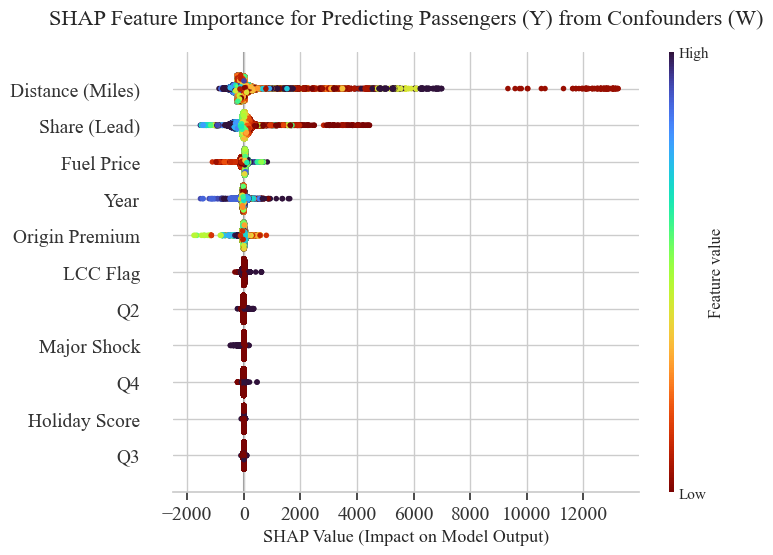


SHAP Summary Plot for E[T|W] (Treatment Model):


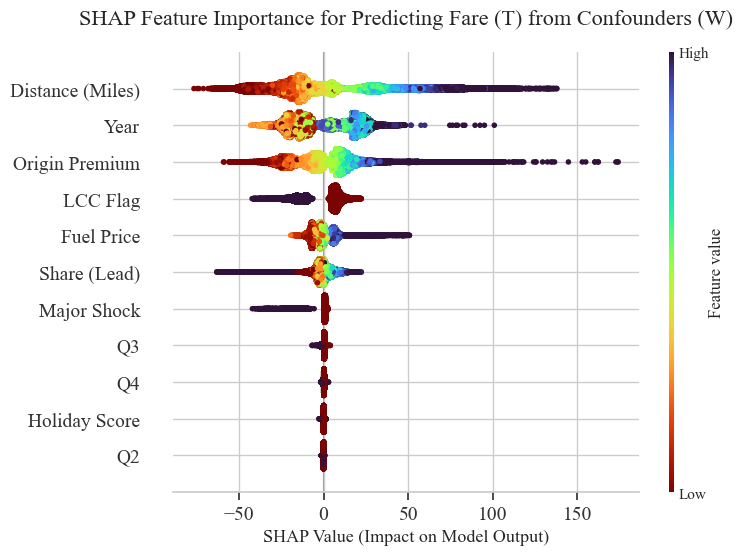

In [176]:
sns.set_context("notebook", font_scale=1.5)
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (11, 8)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

clean_W_columns = [label_map.get(col, col) for col in W.columns]

W_df_scaled = pd.DataFrame(W_np, columns=clean_W_columns) # use scaled W for SHAP plots

print("\nSHAP Summary Plot for E[Y|W] (Outcome Model):")

shap.summary_plot(shap_values_y, W_df_scaled, show=False, cmap="turbo_r")

plt.title('SHAP Feature Importance for Predicting Passengers (Y) from Confounders (W)', pad=20, fontsize=16)
plt.xlabel('SHAP Value (Impact on Model Output)')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../outputs/R_CML_SHAP_predY_from_W.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

print("\nSHAP Summary Plot for E[T|W] (Treatment Model):")

shap.summary_plot(shap_values_t, W_df_scaled, show=False, cmap="turbo_r")

plt.title('SHAP Feature Importance for Predicting Fare (T) from Confounders (W)', pad=20, fontsize=16)
plt.xlabel('SHAP Value (Impact on Model Output)')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('../outputs/R_CML_SHAP_predT_from_W.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

## 8. Final Causal Explanation

In [177]:
print("\n--- Causal Explanation Summary ---")
print(f"The estimated average causal effect (ATE) of a $1 increase in fare is a change of ~{ate_point_estimate:.1f} passengers/day.")
print("However, this effect varies across markets (CATE). Key factors driving heterogeneity may include:")

# Refer to findings from CATE distribution, plots vs features, and interpreter tree
significant_drivers = []
significant_drivers.append("Route distance ('nsmiles')")
significant_drivers.append("Dominant carrier type (LCC vs. Legacy)")
significant_drivers.append("Origin city fare premium level")
significant_drivers.append("Seasonality (Quarter)")
significant_drivers.append("Presence of major holidays")
significant_drivers.append("Average fuel prices")

if significant_drivers:
    for driver in significant_drivers:
        print(f"- {driver}")
else:
    print("- (Further investigation needed to pinpoint significant drivers)")

print("\nUnderstanding these varying effects is crucial for targeted pricing strategies.")



--- Causal Explanation Summary ---
The estimated average causal effect (ATE) of a $1 increase in fare is a change of ~-4.0 passengers/day.
However, this effect varies across markets (CATE). Key factors driving heterogeneity may include:
- Route distance ('nsmiles')
- Dominant carrier type (LCC vs. Legacy)
- Origin city fare premium level
- Seasonality (Quarter)
- Presence of major holidays
- Average fuel prices

Understanding these varying effects is crucial for targeted pricing strategies.


### Extra: Sensitivity Analysis with HighRes


--- Running DML-Based Sensitivity Grid (This will take a moment) ---


/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was p

Grid calculations complete! Generating custom heatmap...


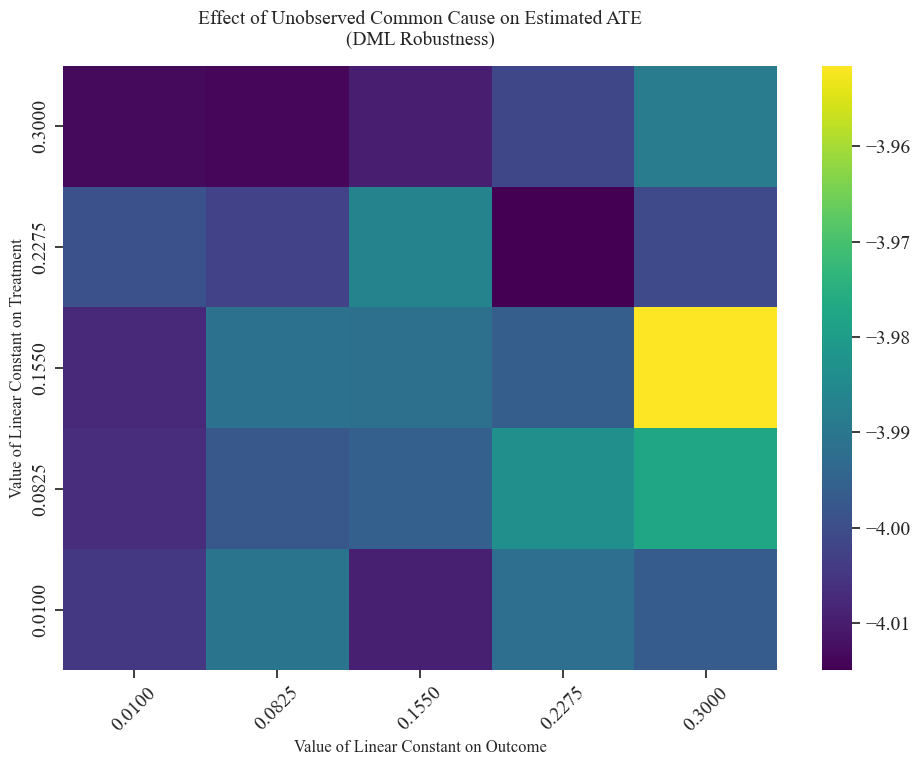

In [ ]:
x_vals = np.linspace(0.01, 0.3, 5)
y_vals = np.linspace(0.01, 0.3, 5)

# 1. Manually build the 5x5 matrix to bypass DoWhy's black box
effects_matrix = np.zeros((5, 5))

print("\n--- Running DML-Based Sensitivity Grid (This will take a moment) ---")
for i, eff_out in enumerate(y_vals):
    for j, eff_trt in enumerate(x_vals):
        # Run refuter for each specific combination
        res = model_dowhy.refute_estimate(
            identified_estimand,
            dml_estimate_dowhy,
            method_name="add_unobserved_common_cause",
            confounders_effect_on_treatment="linear",
            confounders_effect_on_outcome="linear",
            effect_strength_on_treatment=eff_trt,
            effect_strength_on_outcome=eff_out
        )
        
        # Safely extract the single resulting ATE float into our matrix
        effects_matrix[i, j] = np.array(res.new_effect).item()

print("Grid calculations complete! Generating custom heatmap...")

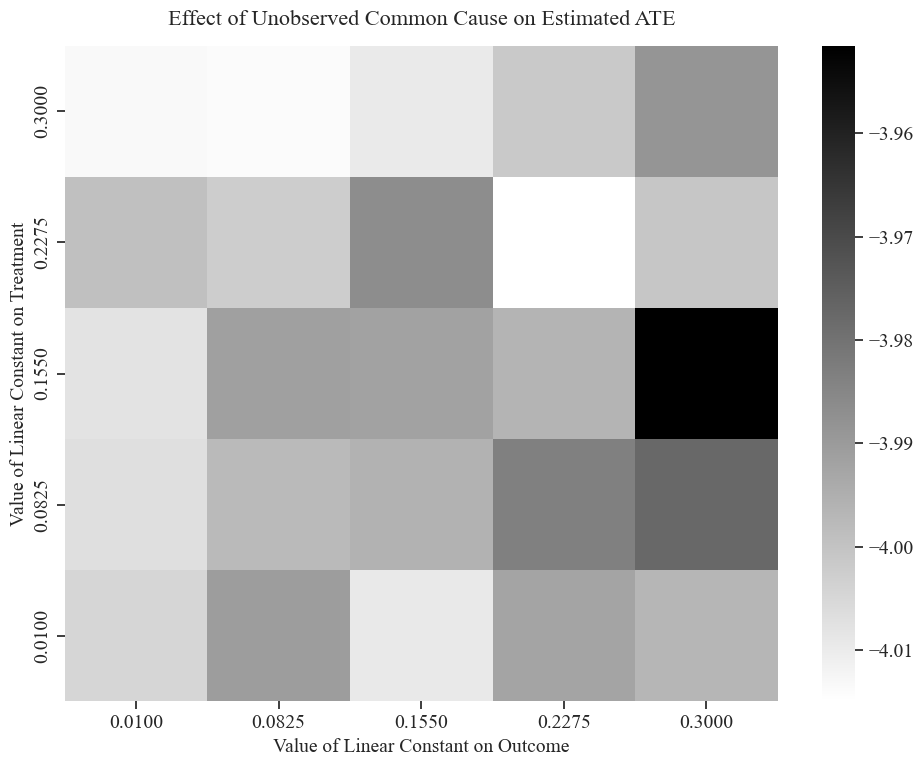

In [190]:
# 2. Draw the heatmap with the colorblind-friendly palette
x_labels = [f"{val:.4f}" for val in x_vals]
y_labels = [f"{val:.4f}" for val in y_vals]

plt.figure(figsize=(10, 8)) 
ax = sns.heatmap(
    effects_matrix, 
    xticklabels=x_labels, 
    yticklabels=y_labels,   
    annot=False,
    cmap="gray_r", 
)

ax.invert_yaxis()

# 3. Apply labeling
plt.title('Effect of Unobserved Common Cause on Estimated ATE', fontsize=16, pad=15)
plt.xlabel('Value of Linear Constant on Outcome', fontsize=14)
plt.ylabel('Value of Linear Constant on Treatment', fontsize=14)

plt.tight_layout()

# 4. SAVE AS PDF
plt.savefig('../outputs/R_CML_heatmap_unobserved_refuter_highres.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()